In [1]:
cd ..

/home/mars/src_aiai


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from src.visualisation import compare
from src.visualisation import plot_statistics, print_statistics
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

# SPIDER

In [4]:
from src.sampling.uv_sampling import spider_sampling

In [5]:
wavebands = np.linspace(500,900, 10) # probably need to do something slightly diffferent
object_distance = 250 #km
lenslet_diameter = 8.75 #mm
longest_baseline = 0.5 #m
n_lenslets = 24
n_PICs = 37
n_specbins = 10

uvs = spider_sampling(normalised=False)

In [6]:
x0 = 0.15
pic = x0 + np.linspace(0,0.5, n_lenslets).reshape(-1,1)
angles = np.linspace(0,2*np.pi, n_PICs, endpoint=False)

coords = np.array([ (pic*np.cos(angles).reshape(1,-1)).flatten(), (pic*np.sin(angles).reshape(1,-1)).flatten()]).T

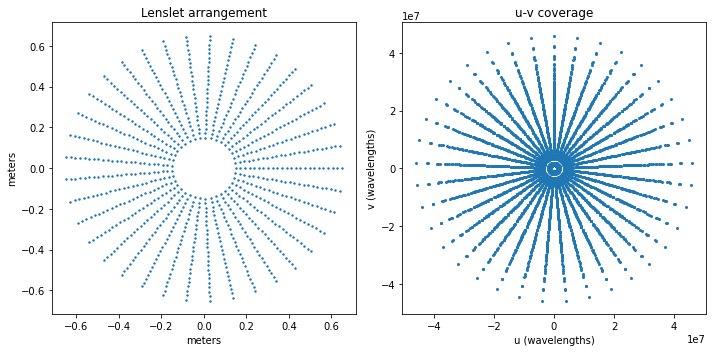

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(coords[:,0], coords[:,1], s=2)
ax[0].set_xlabel('meters')
ax[0].set_ylabel('meters')
ax[0].set_title('Lenslet arrangement')


ax[1].scatter(uvs[:,0], uvs[:,1], s=4)
ax[1].set_xlabel('u (wavelengths)')
ax[1].set_ylabel('v (wavelengths)')
ax[1].set_title('u-v coverage')


plt.tight_layout()
plt.savefig("./plots/spider_config.pdf", transparent = True)
# plt.subplots_adjust(wspace=0.2)

In [ ]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='none', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='none', ecolor='k')

    return artists

In [48]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


box1 = Rectangle((uvs.min(), uvs.min()), uvs.max()*2, uvs.max()*2)
box2 = Rectangle((uvs.min()/2, uvs.min()/2), uvs.max(), uvs.max())

# errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
#               for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

# # Create patch collection with specified colour/alpha
p1 = PatchCollection([box1], facecolor='blue', alpha=.2, edgecolor='red', linewidth=5)
p2 = PatchCollection([box2], facecolor='blue', alpha=.2, edgecolor='red', linewidth=5)


# # Add collection to axes


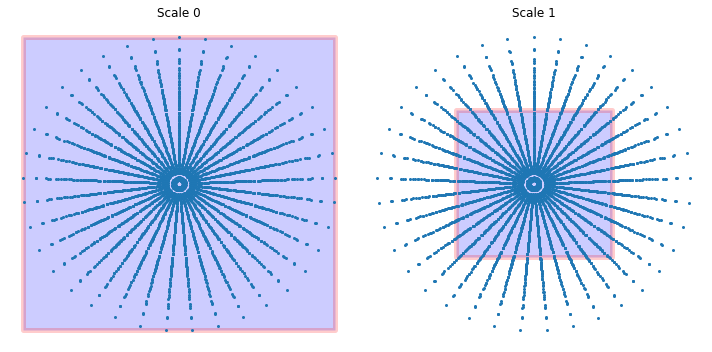

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].add_collection(p1)
ax[1].add_collection(p2)


ax[0].scatter(uvs[:,0], uvs[:,1], s=4)
ax[0].axis('off')
# ax[0].set_xlabel('u (wavelengths)')
# ax[0].set_ylabel('v (wavelengths)')
ax[0].set_title('Scale 0')

ax[1].scatter(uvs[:,0], uvs[:,1], s=4)
ax[1].axis('off')

# ax[1].set_xlabel('u (wavelengths)')
# ax[1].set_ylabel('v (wavelengths)')
ax[1].set_title('Scale 1')


plt.tight_layout()
plt.savefig("./plots/sub_operator.pdf", transparent = True)
# plt.subplots_adjust(wspace=0.2)

### ==TODO check the units on the wavelengths, they differ from Pratley et al. 2021==
maybe add colors to indicate the frequency syntesis?

In [8]:
from src.visualisation import compare
from src.data import load_M51
from src.operators.measurement import NUFFT_op


Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [43]:
uv = spider_sampling()
uv = uv * .5 *np.pi/uv.max()
m_op = NUFFT_op()

Nd = (256, 256)
Kd = (512, 512)
Jd = (6, 6)

m_op.plan(uv, Nd, Kd, Jd)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 4835.03it/s]


In [44]:
x_true = load_M51()

y0 = m_op.dir_op(x_true)
ISNR = 30 #dB
sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
y = y0 #+ noise

x_dirty = m_op.adj_op(y)
noise_val = np.std((m_op.adj_op(noise)))

w = np.linalg.norm(uv, axis=1)
x_f = m_op.adj_op(y*w/w.max())

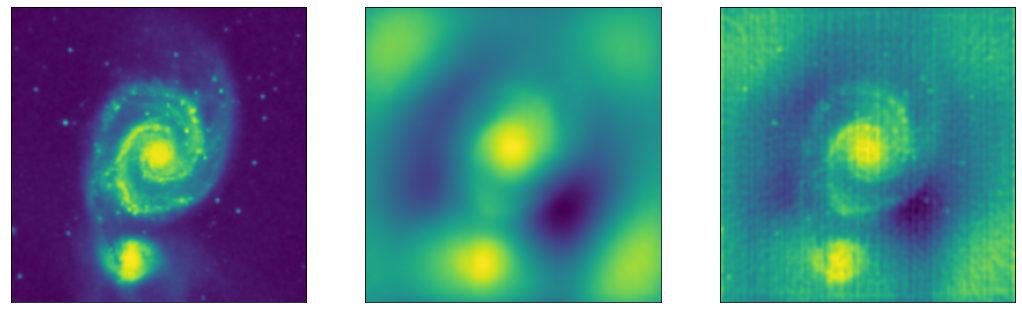

In [45]:
compare([x_true.real, x_dirty.real, x_f.real])